In [5]:
!pip install preflibtools

In [6]:
from preflibtools.instances import OrdinalInstance

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
instance = OrdinalInstance(file_path="00072-00000001.soi")
print(type(instance))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/clones_comsoc/00072-00000001.soi'

In [8]:
import pandas as pd

In [ ]:
full = instance.full_profile()
print(type(full))

In [ ]:
full

In [ ]:
from preflibtools.aggregation import singlewinner

singlewinner.plurality_winner(instance)

In [ ]:
vote_map = instance.vote_map()

In [ ]:
vote_map

In [ ]:
from preflibtools.properties import has_condorcet

has_condorcet(instance)

In [ ]:
flattened = instance.flatten_strict()

In [ ]:
n_voters = instance.num_voters

In [ ]:
n_alts = instance.num_alternatives

In [ ]:
profile = [ballot for ballot in full if len(ballot) == n_alts]

In [ ]:
profile

In [ ]:
import numpy as np

votes = np.asarray(profile).squeeze()

In [ ]:
votes

In [ ]:
names = []

for alt, alt_name in instance.alternatives_name.items():
    names.append(alt_name)

In [ ]:
names

In [ ]:
rankings_2007 = votes
candidates_2007 = names
m_2007 = len(candidates_2007)
# keep only the votes with m_2007 candidates
rankings_2007 = rankings_2007[np.sum(rankings_2007 == 0, axis=1) == 0]
rankings_2007 = np.array([np.argsort(ranking) for ranking in rankings_2007])
clones_val = computeClonesValues(rankings_2007)
print(len(rankings_2007))
print(m_2007)
clones_val_tab = [(candidates_2007[i], candidates_2007[j], clones_val[i][j]) for i in range(len(candidates_2007)) for j in range(i+1, len(candidates_2007)) if clones_val[i][j] > 2/m_2007]
clones_val_tab = sorted(clones_val_tab, key=lambda x: x[2], reverse=True)
print("Clones values for 2007 elections:")
for i in range(10):
    print(f"{clones_val_tab[i][0]} and {clones_val_tab[i][1]}: {clones_val_tab[i][2]}")

alpha function

In [ ]:
def computeClonesValues(votes, weights=None):
    n_voters, m_candidates = votes.shape
    n_clones = np.zeros((m_candidates, m_candidates))
    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_candidates-1):
            n_clones[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones = n_clones + n_clones.T  # make it symmetric

    # return np.max(n_clones)/total_weight
    return n_clones/ total_weight

alpha on 2007 data

In [ ]:
rankings_2007 = pd.read_csv("rankings.csv", index_col=0)
candidates_2007 = rankings_2007.columns.to_numpy()
rankings_2007 = rankings_2007.to_numpy()
m_2007 = len(candidates_2007)
# keep only the votes with m_2007 candidates
rankings_2007 = rankings_2007[np.sum(rankings_2007 == 0, axis=1) == 0]
rankings_2007 = np.array([np.argsort(ranking) for ranking in rankings_2007])
clones_val = computeClonesValues(rankings_2007)
print(len(rankings_2007))
print(m_2007)
clones_val_tab = [(candidates_2007[i], candidates_2007[j], clones_val[i][j]) for i in range(len(candidates_2007)) for j in range(i+1, len(candidates_2007)) if clones_val[i][j] > 2/m_2007]
clones_val_tab = sorted(clones_val_tab, key=lambda x: x[2], reverse=True)
print("Clones values for 2007 elections:")
for i in range(10):
    print(f"{clones_val_tab[i][0]} and {clones_val_tab[i][1]}: {clones_val_tab[i][2]}")

alpha on skate data

In [9]:
# skate
import re
import glob, os
import numpy as np

maxclones = []
pts =[]


for file in glob.glob("00006_skate/*.*oc"):
  ranking = OrdinalInstance(file)
  profile = ranking.full_profile()
  n_alts = ranking.num_alternatives
  profile = [ballot for ballot in profile if len(ballot) == n_alts]
  votes = np.asarray(profile).squeeze()
  votes = votes - 1
  clones_val = computeClonesValues(votes)
  maxclones.append(np.max(clones_val))
  for j in range(len(clones_val)):
      for k in range(j+1, len(clones_val)):
          pts.append(clones_val[j][k])

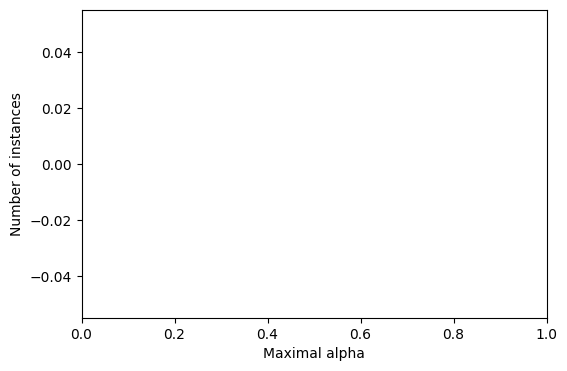

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
# distribution
plt.hist(maxclones, bins=5, color='k', edgecolor='white')
plt.xlim(0,1)
plt.xlabel("Maximal alpha")
plt.ylabel("Number of instances")
plt.savefig("skate.pdf", bbox_inches='tight')
plt.show()

gamma 2007 election

In [11]:
def computeClonesValuesDistancesGamma(votes, weights=None, gamma = 0.5):
    m = votes.shape[1]
    votes = votes[:, 0:round(m*gamma)]

    n_voters, m_candidates = votes.shape

    n_clones_v = np.zeros((m, m))
    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_candidates-1):
            n_clones_v[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones_v = n_clones_v + n_clones_v.T  # make it symmetric

    n_clones_d = np.zeros((m, m))

    for i in range(n_voters):
        for j in range(m_candidates-2):
            for k in range(j+2, m_candidates):
                n_clones_d[votes[i][j]][votes[i][k]] += (k-j-1)*weights[i]
    n_clones_d = n_clones_d + n_clones_d.T  # make it symmetric
    # add "total_weight" to the diagonal
    np.fill_diagonal(n_clones_d, total_weight* (m_candidates - 1))

    # return np.max(n_clones)/total_weight
    return n_clones_v/total_weight, n_clones_d/total_weight

In [13]:
rankings_2007 = pd.read_csv("rankings.csv", index_col=0)
candidates_2007 = rankings_2007.columns.to_numpy()
rankings_2007 = rankings_2007.to_numpy()
m_2007 = len(candidates_2007)
# keep only the votes with m_2007 candidates
rankings_2007 = rankings_2007[np.sum(rankings_2007 == 0, axis=1) == 0]
rankings_2007 = np.array([np.argsort(ranking) for ranking in rankings_2007])
clones_vals_dists = []
gammas = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
print(len(rankings_2007))
print(m_2007)

for gamma in gammas:
  clones_val_dist = computeClonesValuesDistancesGamma(rankings_2007, gamma=gamma)
  clones_vals_dists.append(clones_val_dist)

for a in range(len(clones_vals_dists)):
  clones_val_tab = [(candidates_2007[i], candidates_2007[j], clones_vals_dists[a][0][i][j]) for i in range(len(candidates_2007)) for j in range(i+1, len(candidates_2007))]
  clones_val_tab = sorted(clones_val_tab, key=lambda x: x[2], reverse=True)
  print(f"\nClones values for 2007 elections: (gamma = {gammas[a]})")
  for i in range(10):
    print(f"{clones_val_tab[i][0]} and {clones_val_tab[i][1]}: {clones_val_tab[i][2]}")

  clones_dist_tab = [(candidates_2007[i], candidates_2007[j], clones_vals_dists[a][1][i][j]) for i in range(len(candidates_2007)) for j in range(i+1, len(candidates_2007)) if clones_vals_dists[a][1][i][j] > 0.5]
  clones_dist_tab = sorted(clones_dist_tab, key=lambda x: x[2])
  print(f"\nClones distances for 2007 elections: (gamma = {gammas[a]})")
  for i in range(10):
    print(f"{clones_dist_tab[i][0]} and {clones_dist_tab[i][1]}: {clones_dist_tab[i][2]}")


370
12

Clones values for 2007 elections: (gamma = 0.5)
François Bayrou and Ségolène Royal: 0.32972972972972975
François Bayrou and Nicolas Sarkozy: 0.3108108108108108
Olivier Besancenot and Marie-George Buffet: 0.22702702702702704
Jean-Marie Le Pen and Nicolas Sarkozy: 0.16216216216216217
Ségolène Royal and Nicolas Sarkozy: 0.15945945945945947
Olivier Besancenot and Arlette Laguiller: 0.15135135135135136
Olivier Besancenot and Ségolène Royal: 0.14864864864864866
François Bayrou and Philippe de Villiers: 0.14324324324324325
Olivier Besancenot and François Bayrou: 0.11891891891891893
José Bové and Dominique Voynet: 0.11891891891891893

Clones distances for 2007 elections: (gamma = 0.5)
Philippe de Villiers and Nicolas Sarkozy: 0.5054054054054054
José Bové and Ségolène Royal: 0.527027027027027
François Bayrou and Ségolène Royal: 0.5324324324324324
François Bayrou and Arlette Laguiller: 0.5540540540540541
Olivier Besancenot and Nicolas Sarkozy: 0.5594594594594594
Ségolène Royal and Nicola

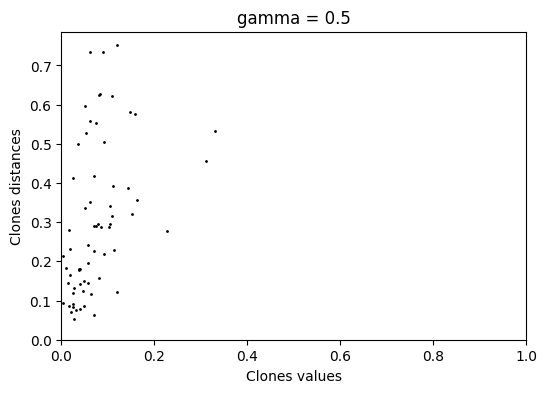

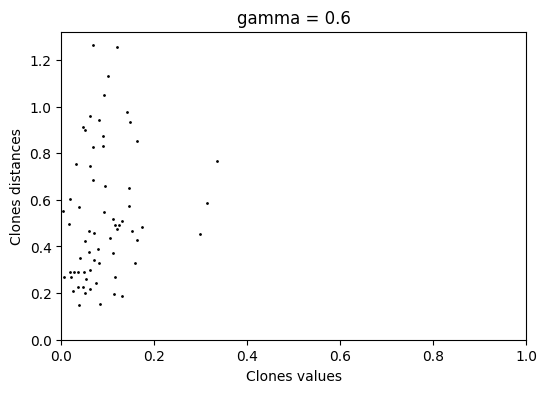

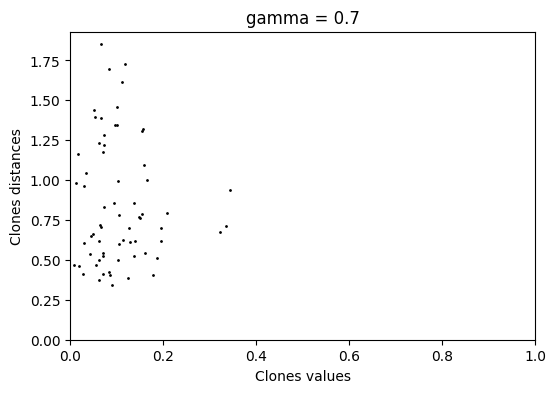

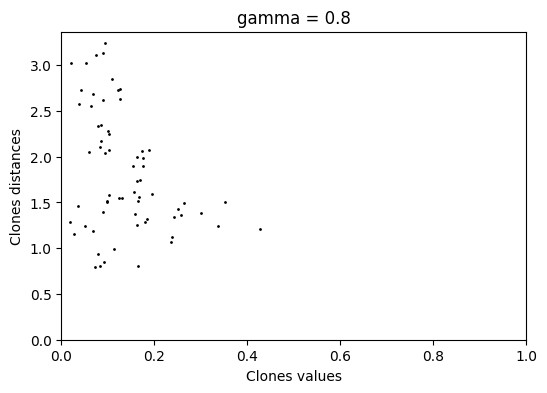

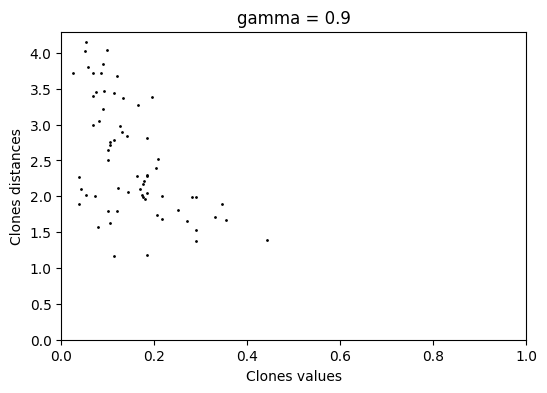

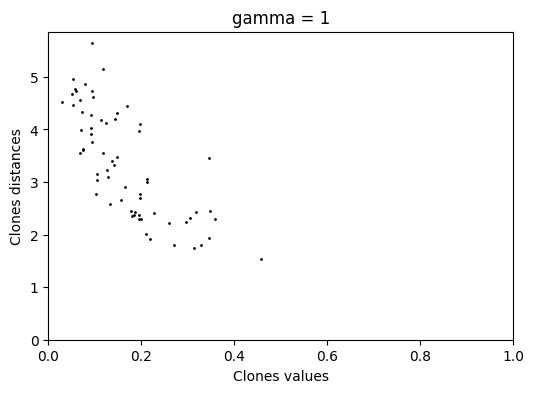

In [14]:
for a in range(len(gammas)):
  pts = []
  for i in range(m_2007):
    for j in range(i+1, m_2007):
      pts.append((clones_vals_dists[a][0][i][j], clones_vals_dists[a][1][i][j]))
  plt.figure(figsize=(6,4))
  plt.scatter([x[0] for x in pts], [x[1] for x in pts], s=1, color='k')
  plt.xlabel("Clones values")
  plt.ylabel("Clones distances")
  plt.title(f"gamma = {gammas[a]}")
  plt.xlim(0,1)
  plt.ylim(0)
# plt.savefig("clones_correl_2007.pdf", bbox_inches='tight')
  plt.show()

  pts_2007 = pts

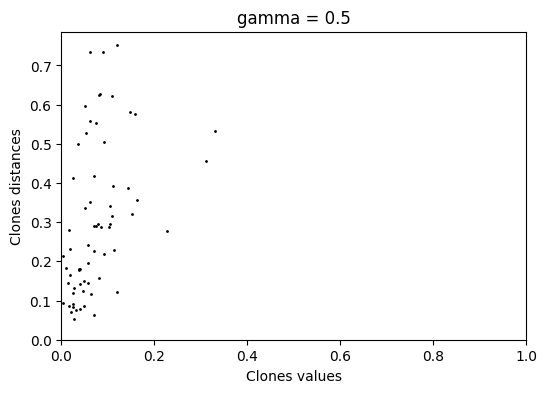

In [19]:
pts = []
for i in range(m_2007):
  for j in range(i+1, m_2007):
    pts.append((clones_vals_dists[0][0][i][j], clones_vals_dists[0][1][i][j]))
plt.figure(figsize=(6,4))
plt.scatter([x[0] for x in pts], [x[1] for x in pts], s=1, color='k')
plt.xlabel("Clones values")
plt.ylabel("Clones distances")
plt.title(f"gamma = {gammas[0]}")
plt.xlim(0,1)
plt.ylim(0)
plt.savefig("clones_correl_2007_0.5.pdf", bbox_inches='tight')
plt.show()

pts_2007 = pts

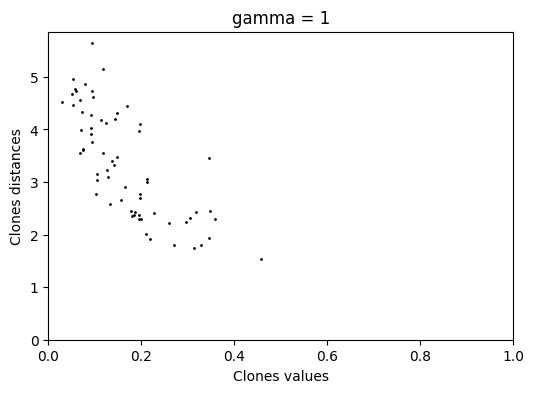

In [20]:
pts = []
for i in range(m_2007):
  for j in range(i+1, m_2007):
    pts.append((clones_vals_dists[5][0][i][j], clones_vals_dists[5][1][i][j]))
plt.figure(figsize=(6,4))
plt.scatter([x[0] for x in pts], [x[1] for x in pts], s=1, color='k')
plt.xlabel("Clones values")
plt.ylabel("Clones distances")
plt.title(f"gamma = {gammas[5]}")
plt.xlim(0,1)
plt.ylim(0)
plt.savefig("clones_correl_2007_1.pdf", bbox_inches='tight')
plt.show()

pts_2007 = pts

gamma skate

In [23]:
pts_pts=[]
max_clones = []
clonesdists = []

for a in range(len(gammas)):
  maxclones = []
  clonesdist = []
  pts = []

  for file in glob.glob("*.*oc"):
    ranking = OrdinalInstance(file)
    profile = ranking.full_profile()
    n_alts = ranking.num_alternatives
    profile = [ballot for ballot in profile if len(ballot) == n_alts]
    votes = np.asarray(profile).squeeze()
    votes = votes - 1
    clones_val, clones_dist = computeClonesValuesDistancesGamma(votes, gamma=gammas[a])
    maxclones.append(np.max(clones_val))
    clonesdist.append(np.min(clones_dist))
    for j in range(len(clones_val)):
        for k in range(j+1, len(clones_val)):
            pts.append((clones_val[j][k], clones_dist[j][k]))

  max_clones.append(maxclones)
  clonesdists.append(clonesdist)
  pts_pts.append(pts)

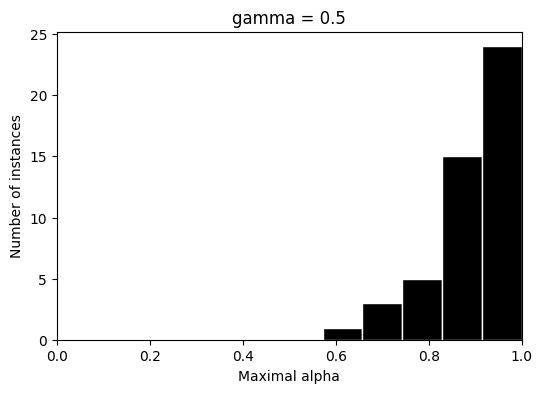

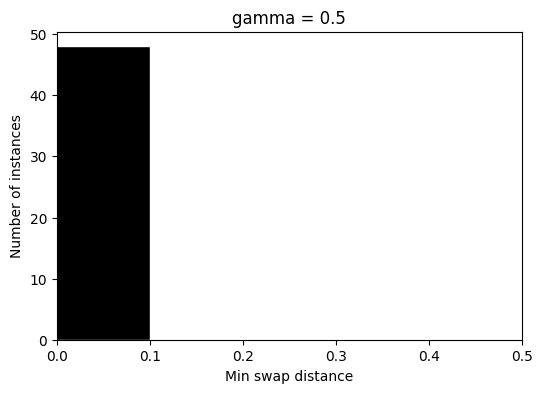

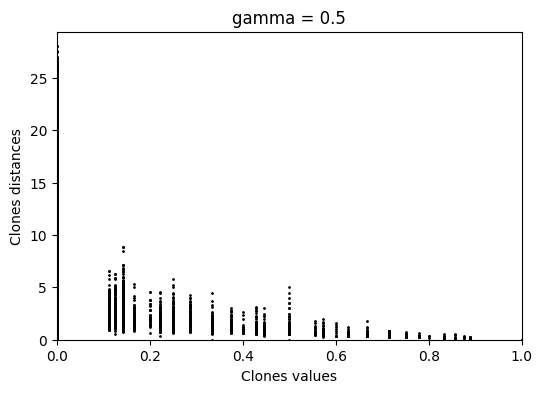

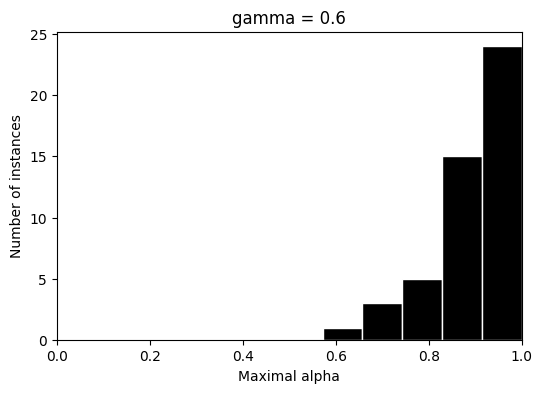

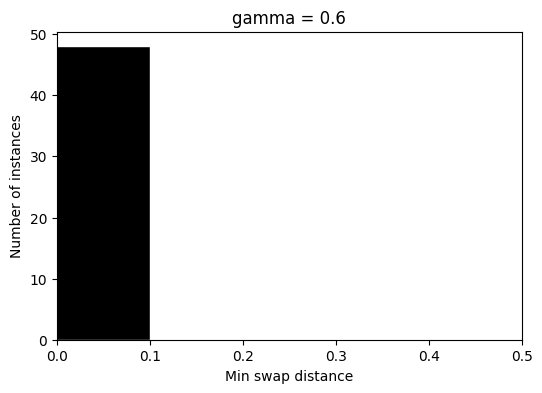

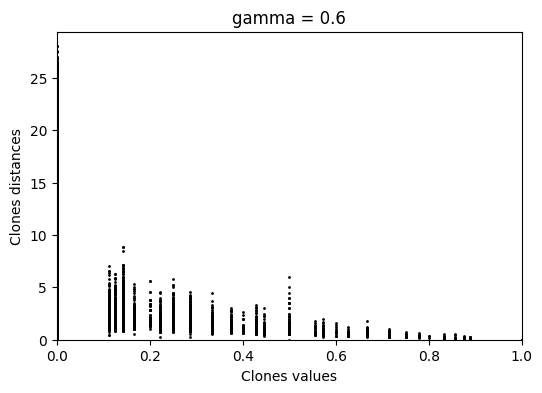

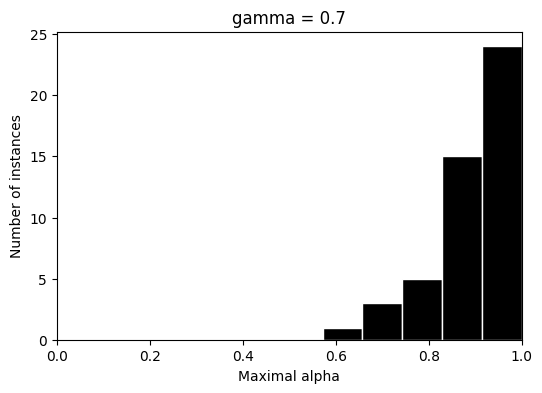

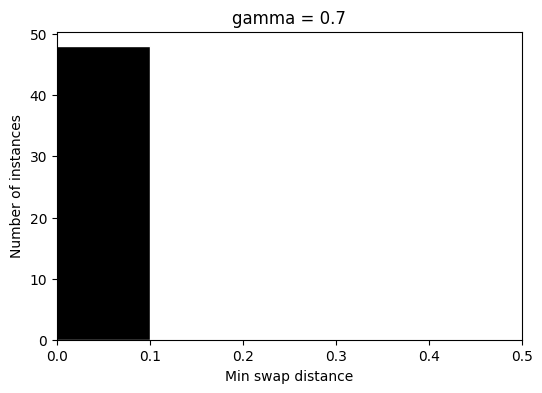

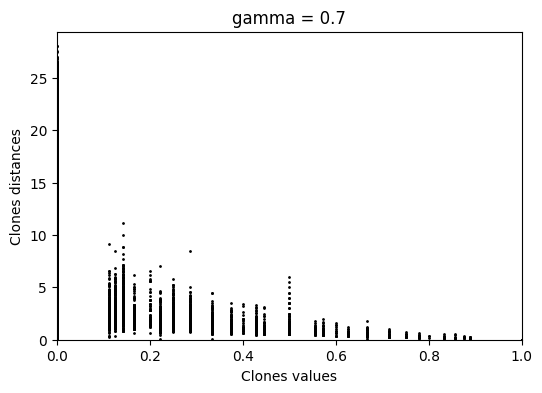

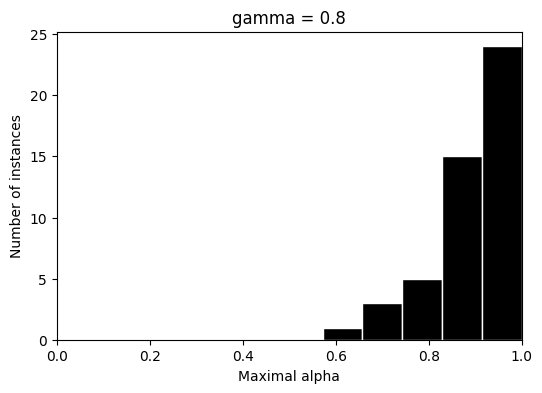

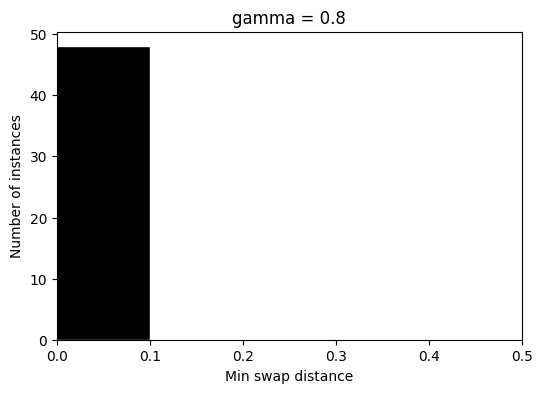

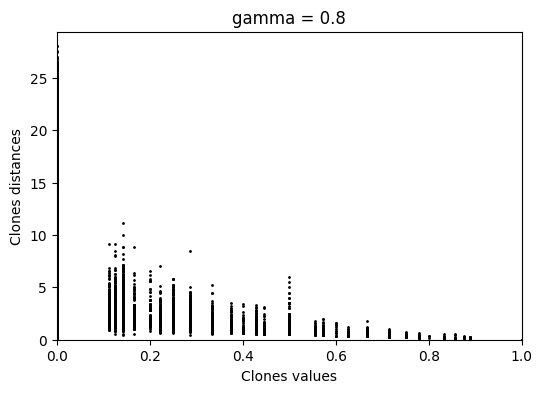

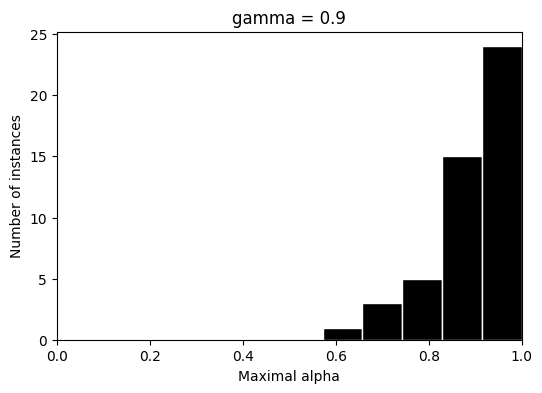

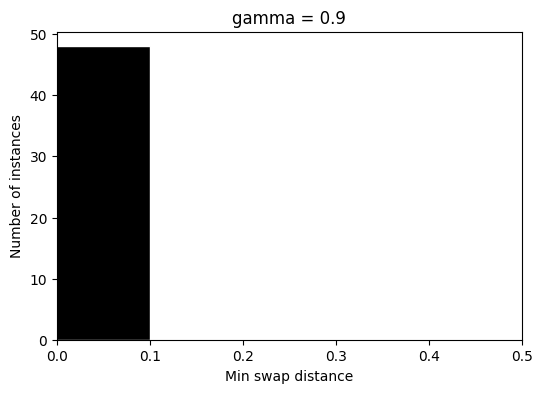

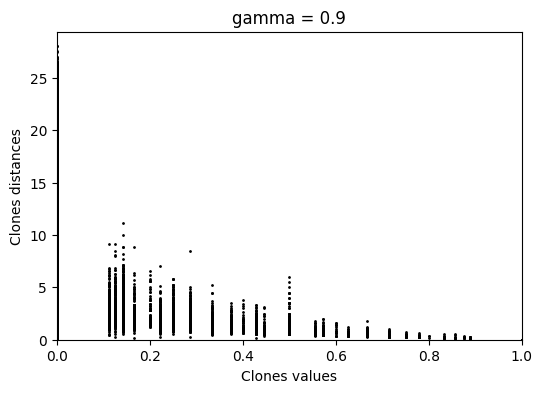

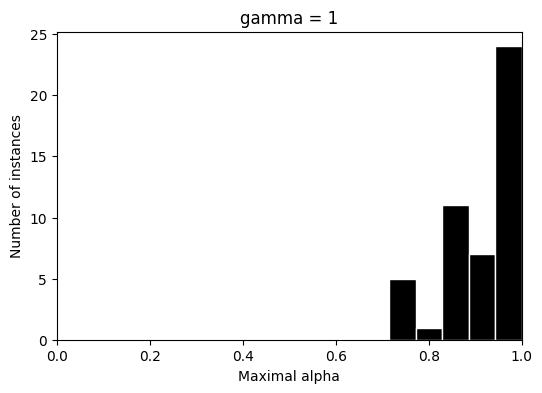

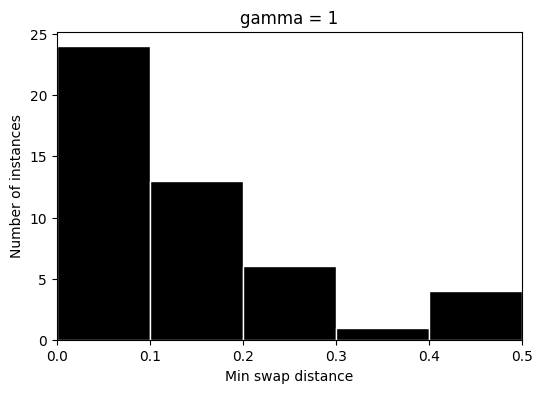

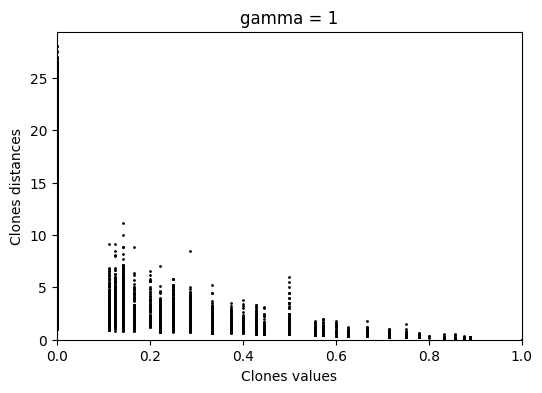

In [24]:
for a in range(len(gammas)):

  plt.figure(figsize=(6,4))
  # distribution
  plt.hist(max_clones[a], bins=5, color='k', edgecolor='white')
  plt.xlim(0,1)
  plt.xlabel("Maximal alpha")
  plt.ylabel("Number of instances")
  plt.savefig("skate.pdf", bbox_inches='tight')
  plt.title(f"gamma = {gammas[a]}")
  plt.show()

  plt.figure(figsize=(6,4))
  # distribution
  plt.hist(clonesdists[a], bins=5, color='k', edgecolor='white')
  plt.xlim(0,0.5)
  plt.xlabel("Min swap distance")
  plt.ylabel("Number of instances")
  plt.savefig("skate_swap.pdf", bbox_inches='tight')
  plt.title(f"gamma = {gammas[a]}")
  plt.show()

  plt.figure(figsize=(6,4))
  plt.scatter([x[0] for x in pts_pts[a]], [x[1] for x in pts], s=1, color='k')
  plt.xlabel("Clones values")
  plt.ylabel("Clones distances")
  plt.title(f"gamma = {gammas[a]}")
  plt.xlim(0,1)
  plt.ylim(0)
  # plt.savefig("clones_correl_skate.pdf", bbox_inches='tight')
  plt.show()

**Local clones:**

$x,y \in A$ are local clones w.r.t. $S \subseteq A$ iff the Tideman condition holds for all $z \in S$

In [ ]:
# get the data

# skate
import re
import glob, os
import numpy as np

maxclones = []
pts =[]


# for file in glob.glob("/content/drive/My Drive/clones_comsoc/00006_skate/*.*oc"):
#   ranking = OrdinalInstance(file)
#   profile = ranking.full_profile()
#   n_alts = ranking.num_alternatives
#   profile = [ballot for ballot in profile if len(ballot) == n_alts]
#   votes = np.asarray(profile).squeeze()
#   votes = votes - 1

testfile = "00006-00000001.toc"
ranking = OrdinalInstance(testfile)
profile = ranking.full_profile()
n_alts = ranking.num_alternatives
profile = [ballot for ballot in profile if len(ballot) == n_alts]
votes = np.asarray(profile).squeeze()
votes = votes - 1

print(type(votes))


The following is a function for modifying the profile to a new one over a subset of candidates S, rather than the original set of candidates A

In [ ]:
import numpy as np

array = np.array([[0,1,2],[2,0,1]])
delete = np.array([0])

def restrictProfile(array, delete):
  newlist = []
  for row in array:
    mask = np.isin(row, delete)
    newrow = row[np.logical_not(mask)]
    newlist.append(newrow)
  newarray = np.array(newlist, dtype=object)
  return newarray

print(restrictProfile(array, delete))

In [ ]:
# 0 and 1 are left wing
# 3 is right wing
# 2 is centrist
# so 0 and 1 are clones w.r.t. 3, but not 2
# 3 never comes between 0 and 1
# if the set of alternatives didn't include 2, then 0 and 1 would be tideman clones

raw = [
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3],
    [0,2,1,3],
    [3,2,1,0],
    [0,1,3,2],
    [3,1,0,2],
    [0,1,3,2]
]


votes = np.array(raw)

remove = np.array([2])

print(restrictProfile(votes, remove))


The following function computes the clone values for a modified profile,

In [ ]:
newvotes = restrictProfile(votes, remove)

def computeLocalClonesValues(votes, weights=None):
    n_voters, m_ranks = votes.shape # m_ranks is the number of ranked positions in each vote

    # Determine the total number of unique candidates by finding the maximum candidate ID
    # This assumes candidate IDs are non-negative and 0-indexed for matrix access.
    m_candidates = np.max(votes) + 1

    n_clones = np.zeros((m_candidates, m_candidates))

    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_ranks-1):
            n_clones[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones = n_clones + n_clones.T

    return n_clones / total_weight

clones = computeLocalClonesValues(newvotes)
print(clones)

In [ ]:
def computeClonesValues(votes, weights=None):

    n_voters, m_candidates = votes.shape
    n_clones = np.zeros((m_candidates, m_candidates))
    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_candidates-1):
            n_clones[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones = n_clones + n_clones.T  # make it symmetric

    # return np.max(n_clones)/total_weight
    return n_clones/ total_weight

clones = computeClonesValues(votes)
print(clones)

In [ ]:
def computeClonesValuesDistancesGamma(votes, weights=None, gamma = 0.5):
    m = votes.shape[1]
    votes = votes[:, 0:round(m*gamma)]

    n_voters, m_candidates = votes.shape

    n_clones_v = np.zeros((m, m))
    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_candidates-1):
            n_clones_v[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones_v = n_clones_v + n_clones_v.T  # make it symmetric

    n_clones_d = np.zeros((m, m))

    for i in range(n_voters):
        for j in range(m_candidates-2):
            for k in range(j+2, m_candidates):
                n_clones_d[votes[i][j]][votes[i][k]] += (k-j-1)*weights[i]
    n_clones_d = n_clones_d + n_clones_d.T  # make it symmetric
    # add "total_weight" to the diagonal
    np.fill_diagonal(n_clones_d, total_weight* (m_candidates - 1))

    # return np.max(n_clones)/total_weight
    return n_clones_v/total_weight, n_clones_d/total_weight

clones = computeClonesValuesDistancesGamma(votes)
print((clones[0]).shape)

In [ ]:
# subset is the parameter for S
# it's the subset of the alternatives with respect to which the pair are clones

def computeLocalClonesValues(votes, subset, weights=None):
    n_voters, m_candidates = votes.shape
    n_clones = np.zeros((m_candidates, m_candidates))
    if weights is None:
        weights = np.ones(n_voters)

    total_weight = np.sum(weights)

    for i in range(n_voters):
        for j in range(m_candidates-1):
            n_clones[votes[i][j]][votes[i][j+1]] += weights[i]
    n_clones = n_clones + n_clones.T  # make it symmetric

    # return np.max(n_clones)/total_weight
    return n_clones/ total_weight

clones = computeClonesValues(votes)
print(clones)